# **Práctica 2**
**Autores:** José María García Ortiz, Levi Malest Villareal y Ana Gil Molina

In [1]:
# Cargamos aquí las librerías que vamos a utilizar:


import skimage.transform as transform
import skimage.exposure as exposure
import skimage.filters as filters
import skimage.color as color
import skimage.morphology as morphology
import skimage.restoration as restoration


import random
import numpy as np
import math
import matplotlib.pyplot as plt
import skimage
import cv2
import matplotlib

from matplotlib import patches
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Rectangle
from scipy import ndimage as ndi
from ipywidgets import FloatSlider, interact, fixed

# from google.colab.patches import cv2_imshow
from skimage import measure

## Código para leer ficheros desde Drive

In [ ]:
from google.colab import drive
import os
import shutil
import gdown
import zipfile


# IDs de los archivos compartidos (reemplaza con los IDs de tus archivos .zip)
file_ids = ['1Cen9C8JUsS9zEaM9r0abyyC8cfu8g1YH', '1U3l67Tw6-KsrPI9AQ9NullORE9U1G7UQ']  # Cambia estos IDs por los de tus archivos

    #https://drive.google.com/file/d/1Cen9C8JUsS9zEaM9r0abyyC8cfu8g1YH/view?usp=sharing

# Nombres locales para los archivos descargados y descomprimidos
download_paths = ['/CVFiles.zip', '/stereopairs.zip']
extract_paths = ['', '']

# Descargar y descomprimir cada archivo
for file_id, download_path, extract_path in zip(file_ids, download_paths, extract_paths):
    # Descargar archivo
    gdown.download(f'https://drive.google.com/uc?id={file_id}', download_path, quiet=False)

    # Descomprimir el archivo ZIP
    with zipfile.ZipFile(download_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
        print(f"Archivos descomprimidos en '{extract_path}'")

## <div style="background-color: #54c7ec; color: #fff; font-weight: 700; padding-left: 10px; padding-top: 5px; padding-bottom: 5px"><strong>Ejercicio RC2A (0.75 pts)</strong></div>

* Utilizando la técnica RANSAC vista en la teoría de la asignatura, codificar en python una sencilla función de aplicación de la misma, que estime una recta de modo robusto 
a partir de los puntos de borde activos extraidos por el algoritmo de Canny en una determinada región de interés (ROI).

### - ``Definición de funciones auxiliares``

* *RANSAC_single_fit* :   
Ejecuta el método RASNAC sobre una imagen dada, y devuelve la mejor línea que el método puede encontrar.  
Además hace un plot donde podemos ver la línea en cuestión sobre la imagen de entrada en color rojo

* *RANSAC_single_segment* :   
Hace lo mismo que la anterior pero mostrando (y devolviendo) el segmento exacto de la recta que se ajuste al borde detectado por el operador de Canny sobre la imagen dada

In [2]:
def RANSAC_single_fit(image, Canny_threshold1=100, Canny_threshold2=200, num_iterations=100, inliers_threshold=2, min_inliers=50,show=True):

    ''' Implementa a mano el metodo RANSAC para que detecte una línea en la imagen dada '''

    # Obtenemos los puntos de borde con el operador de Canny
    edges = cv2.Canny(image,Canny_threshold1,Canny_threshold2)   # (imagen,threshold1,threshold2)

    # Encuentra puntos de borde
    points = np.argwhere(edges != 0)  # Encuentra coordenadas (y, x) de bordes
    points = np.flip(points, axis=1)  # Invierte a (x, y)

    best_line = None
    max_inliers = 0


    for _ in range(num_iterations):
        
        # Selecciona aleatoriamente dos puntos de borde
        sample_points = points[np.random.choice(points.shape[0], 2, replace=False)]

        # Define la recta (y = mx + b) usando los dos puntos
        (x1, y1), (x2, y2) = sample_points
        if x1 == x2:  # Evita la división por cero
            continue
        m = (y2 - y1) / (x2 - x1)  # sin(alpha) para la pendiente de la recta
        b = y1 - m * x1            # b se despeja trivialmente conociendo m

        # Calcula los inliers
        inliers = []
        for x, y in points:
            distance = abs(m * x - y + b) / np.sqrt(m**2 + 1)   # Calculamos la distancia del punto (x,y) a la recta con al fórmula clásica
            if distance < inliers_threshold:                    # Si la distancia es menos que nuestro umbral de aceoptación, el punto (x,y) se considera inlier
                inliers.append((x, y))

        # Comprueba si es el mejor modelo hasta ahora y guarda entonces la recta inducida por el par de puntos seleccionado
        if len(inliers) > max_inliers and len(inliers) > min_inliers:
            max_inliers = len(inliers)
            best_line = (m, b)
    
    if show == True:
        # Dibuja la recta en la imagen
        if best_line is not None:
            m, b = best_line        # Parámetros que definen a la recta que mejor se aproxima (contiene mas inliers)
            h, w = image.shape[1] , image.shape[0]
            pt1 = (0, int(b))
            pt2 = (w, int(m * w + b))
            image_with_line = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            cv2.line(image_with_line, pt1, pt2, (255, 0, 0), 2)        # Escogemos dos puntos en la recta que nos sirven para imprimirla sobre la imagen en rojo

            # Muestra la imagen con la recta estimada
            plt.imshow(image_with_line)
            plt.axis('off')  # Ocultar los ejes
            plt.title("RANSAC Line Fitting")
            plt.show()
        else:
            print("No se encontró una línea válida.")  

    return best_line


In [3]:
def RANSAC_single_segment(image, Canny_threshold1=100, Canny_threshold2=200, num_iterations=100, inliers_threshold=2, min_inliers=50,show=True):

    ''' Implementa el método RANSAC para detectar un segmento de línea en la imagen dada, con filtrado de inliers descentralizados '''

    # Obtenemos los puntos de borde con el operador de Canny
    edges = cv2.Canny(image, Canny_threshold1, Canny_threshold2)

    # Encuentra puntos de borde
    points = np.argwhere(edges != 0)  # Encuentra coordenadas (y, x) de bordes
    points = np.flip(points, axis=1)  # Invierte a (x, y)

    best_line = None
    max_inliers = 0
    best_inliers = []

    for _ in range(num_iterations):
        
        # Selecciona aleatoriamente dos puntos de borde
        sample_points = points[np.random.choice(points.shape[0], 2, replace=False)]

        # Define la recta (y = mx + b) usando los dos puntos
        (x1, y1), (x2, y2) = sample_points
        if x1 == x2:  # Evita la división por cero
            continue
        m = (y2 - y1) / (x2 - x1)  # Pendiente
        b = y1 - m * x1            # Intercepto

        # Calcula los inliers
        inliers = []
        for x, y in points:
            distance = abs(m * x - y + b) / np.sqrt(m**2 + 1)   # Distancia del punto (x,y) a la recta
            if distance < inliers_threshold:                    # Si es inlier
                inliers.append((x, y))

        # Guarda el mejor modelo
        if len(inliers) > max_inliers and len(inliers) > min_inliers:
            max_inliers = len(inliers)
            best_line = (m, b)
            best_inliers = inliers
    
    if show:
        # Dibuja el segmento en la imagen
        if best_line is not None:
            m, b = best_line
            # Encuentra los puntos extremos del segmento usando los inliers filtrados
            inliers_x = np.array([x for x, y in best_inliers])
            inliers_y = np.array([y for x, y in best_inliers])

            # Filtrado de puntos extremos mediante percentiles
            lower_percentile = 10  # Ajustable
            upper_percentile = 90  # Ajustable
            x_start = np.percentile(inliers_x, lower_percentile)
            x_end = np.percentile(inliers_x, upper_percentile)
            y_start = int(m * x_start + b)
            y_end = int(m * x_end + b)

            # Dibuja el segmento en la imagen
            image_with_segment = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            cv2.line(image_with_segment, (int(x_start), y_start), (int(x_end), y_end), (255, 0, 0), 2)

            # Muestra la imagen con el segmento
            plt.imshow(image_with_segment)
            plt.axis('off')  # Ocultar los ejes
            plt.title("RANSAC Segment Fitting with Filtered Inliers")
            plt.show()
        else:
            print("No se encontró un segmento válido.")  

    return best_line, best_inliers


### - ``Prueba 1``

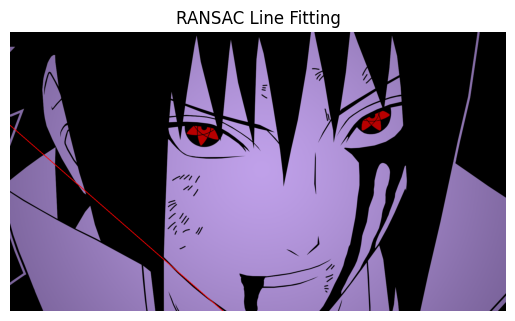

In [ ]:
imgName = "ComputerVisionFiles/sasuke.png"
image = cv2.imread(imgName)
lines = RANSAC_single_fit(image)

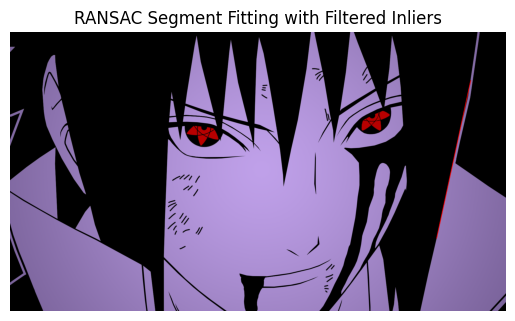

In [6]:
segment = RANSAC_single_segment(image)

### - ``Prueba 2``

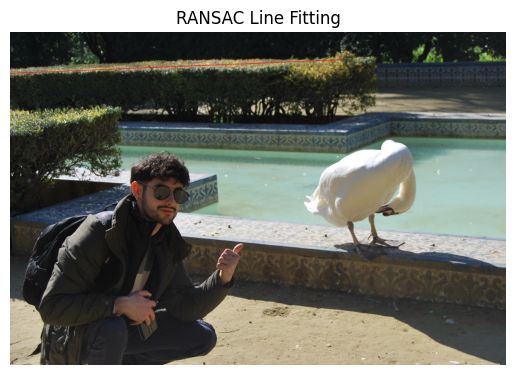

In [ ]:
# tarda 24s

imgName = "ComputerVisionFiles/pato_grande.JPG"
image = cv2.imread(imgName)
lines = RANSAC_single_fit(image, Canny_threshold1=70, Canny_threshold2=200)

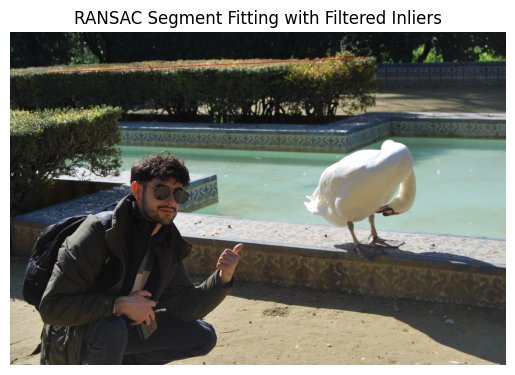

In [24]:
segment = RANSAC_single_segment(image, Canny_threshold1=100, Canny_threshold2=250)

### - ``Prueba 3``

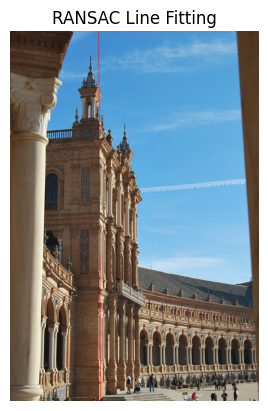

In [ ]:
# tarda 43s

imgName = "ComputerVisionFiles/plaza_espana.jpg"
image = cv2.imread(imgName)
lines = RANSAC_single_fit(image, Canny_threshold1=100, Canny_threshold2=150)

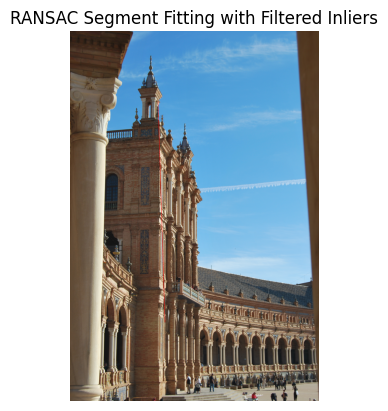

In [19]:
segment = RANSAC_single_segment(image, Canny_threshold1=100, Canny_threshold2=150)

### - ``Conclusiones``

1. En las pruebas realziadas con la primera imagen, la mayoría tenían un resultado satisfactorio, tanto al detectar rectas como al detectar segmentos.

2. Tras realziar varias pruebas con la imagen 2, la amyoría de las veces teníaa problemas para sacar una recta evidente. Podemos sospechar que quizá se deba a que esta imagen en concreto    
es poco deseable de cara a obtener buenos bordes con Canny. Además, al aplicar Canny se confunde curiosamente el cambio de iluminación sobre el seto del fondo con un borde de la imagen.  
Esto seguía sucediendo uncluso jugando con distintos umbrales, y muestra nua forma curiosa de desafiar la robustez del método RANSAC.

3. En la prueba 3 el resultado es bastante bueno, ya que elegí esta fondo pensando en que la líneas verticales fuesen muy obvias, y además,   
presenta cambios de iluminación que alimentan bien la detección de bordes previa a aplicar RANSAC

## <div style="background-color: #54c7ec; color: #fff; font-weight: 700; padding-left: 10px; padding-top: 5px; padding-bottom: 5px"><strong>Ejercicio RC2B (0.75 pts)</strong></div>

- Demostrar su funcionamiento mediante un caso práctico, en el que se seleccione una ROI de una imagen cualquiera en la que,  
además de una recta dominante, aparezcan puntos activos claramente fuera de la misma, que distorsionen la estimación por mínimos cuadrados  
(p.e. una esquina de la plantilla del notebook de ejemplo).

In [47]:
import ipywidgets as widgets
from ipywidgets import interact, fixed, Button
from IPython.display import display, clear_output

### - ``Definición de funciones auxiliares``

* *ROI_selection_colab* :   
Recorta interactivamente, una región rectangular sobre una imagen dada; y devuelve una lista con parámetros que determinan unívocamente esta región de la imagen

* *active_points_plot* :   
Dibuja sobre la imagen dada, los puntos que quedan activos tras aplicarle el operador de Canny y devuelve una tupla con 2 listas, asociadas a las coordenadas X e Y de dichos puntos

* *RANSAC_loop_with_points_ROI* :   
Ejecuta el método RASNAC en bucle sobre una imagen dada, y hace uso de las dos funciones anteriores


In [2]:
def ROI_selection(imgRoute,w=42,h=42,resize_factor=0.5):  

    ''' Devuelve una tupla con los parámetros que determinan unívocamente un parche rectangular sobre una imagen 2-D (Coordenada X del centro, Coordenada Y del centro, 
        radio de anchura y radio de altura) '''

    img1 = cv2.imread(imgRoute)
    img1 = cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)    

    # resize de la imagen original para que quepa en la ventana gráfica que se abrirá después
    if img1.shape[1]>1000:
        s1 = int(img1.shape[1]*resize_factor)
        s2 = int(img1.shape[0]*resize_factor)
        dim = (s1, s2)
        img1 = cv2.resize(img1, dim, interpolation=cv2.INTER_LINEAR)
    
    # Definimos las coordenadas del centro de la imagen resizeada
    Y = int(img1.shape[0]/2)           
    X = int(img1.shape[1]/2)           

    
    
    # Función que no hace nada (para inicializar los sliders)
    def nothing(x):
        pass


    # Inicializamos de forma vacía las variables que vamos a usar para programar el código que fabrica los sliders

    patch_X_coord = 0
    patch_Y_coord = 0


    # Creamos una nueva ventana para los sliders y la imagen
    windowName = "Elegir ROI   --->   [ presione 'Q' para guardar y salir   |   presione 'R' para restablecer valores ]"
    cv2.namedWindow(windowName)

    # Creamos los sliders ---> (nombre del slider en la nueva ventana, especificar la ventana, valor inicial del slider por defecto, valor máximo del slider,...)
    cv2.createTrackbar('X',windowName,X-w,img1.shape[1]-2*w-1,nothing)      
    cv2.createTrackbar('Y',windowName,Y-h,img1.shape[0]-2*h-1,nothing)      


    # Creamos la figura para el próximo plot fuera del bucle while
    plt.figure(figsize=(8, 6))


    while True:
        # Obtenemos los valores actuales de los sliders (También aquí se manifiesta el recorte de las coordenadas de los sliders con +h y +w para que todo cuadre).          
        patch_X_coord = cv2.getTrackbarPos('X',windowName)+w
        patch_Y_coord = cv2.getTrackbarPos('Y',windowName)+h


        # Mostrar sobre la imagen el rectángulo rojo asociado al parche seleccionado
        new_image = img1.copy()
        cv2.rectangle(new_image,(patch_X_coord-w,patch_Y_coord-h),(patch_X_coord+w,patch_Y_coord+h),color=(0,0,255),thickness=1)
        cv2.imshow(windowName, new_image)

        # Salir del bucle y guardar los valores si se presiona la tecla 'Q' o restablecer sliders a valores por defecto presionando la tecla 'R'
        key = cv2.waitKey(1) & 0xFF
        if key == ord('q'):
            break
        elif key == ord('r'):  # Al presionar 'R', restablecer valores  --->  (nombre del slider , valor por defecto asociado)
            patch_X_coord = cv2.setTrackbarPos('X',windowName,X-w)
            patch_Y_coord = cv2.setTrackbarPos('Y',windowName,Y-h)


    # Liberar recursos y cerrar las ventanas
    cv2.destroyAllWindows()


    # Devolvemos las coordenadas del centro de la ROI y hu ancho y alto para que sea determinable de forma unívoca sobre la imagen
    return (patch_X_coord,patch_Y_coord,w,h)

In [3]:
def ROI_selection_colab(image_path,w=42,h=42,resize_factor=0.8):
    
    # Cargar la imagen
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    if image.shape[1]>1000:
        s1 = int(image.shape[1]*resize_factor)
        s2 = int(image.shape[0]*resize_factor)
        dim = (s1, s2)
        image = cv2.resize(image, dim, interpolation=cv2.INTER_LINEAR)

    # Crear sliders para las coordenadas del centro y tamaño del rectángulo
    center_x_slider = widgets.IntSlider(value=image.shape[1] // 2, min=0, max=image.shape[1], description='Center X:')
    center_y_slider = widgets.IntSlider(value=image.shape[0] // 2, min=0, max=image.shape[0], description='Center Y:')
    #width_slider = widgets.IntSlider(value=100, min=1, max=image.shape[1], description='Width:')
    #height_slider = widgets.IntSlider(value=100, min=1, max=image.shape[0], description='Height:')
    
    # Botón para guardar la ROI
    button = widgets.Button(description="Guardar ROI")

    # Función para mostrar la imagen con el rectángulo
    def show_image_with_rectangle(center_x, center_y):
        # Crear una copia de la imagen
        img_copy = image.copy()
        
        # Calcular las coordenadas del rectángulo
        top_left = (int(center_x - w), int(center_y - h))
        bottom_right = (int(center_x + w), int(center_y + h))
        
        # Dibujar el rectángulo en la imagen
        cv2.rectangle(img_copy, top_left, bottom_right, (255, 0, 0), 2)
        
        # Mostrar la imagen
        plt.imshow(img_copy)
        plt.axis('off')
        plt.show()

    # Función para obtener y guardar la ROI
    def get_roi_and_save(b):
        # Calcular las coordenadas del rectángulo
        top_left = (int(center_x_slider.value - w), int(center_y_slider.value - h))
        bottom_right = (int(center_x_slider.value + w), int(center_y_slider.value + h))
        
        # Extraer la ROI
        roi = image[top_left[1]:bottom_right[1], top_left[0]:bottom_right[0]]
        
        # Mostrar la ROI
        plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()
        
        # Guardar la ROI
        cv2.imwrite('roi.jpg', roi)
        print("ROI guardada como 'roi.jpg'.")
        print("Coordenadas del rectángulo:")
        print("Esquina superior izquierda:", top_left)
        print("Esquina inferior derecha:", bottom_right)

    button.on_click(get_roi_and_save)

    # Interactuar con los sliders
    interact(show_image_with_rectangle,
             center_x=center_x_slider,
             center_y=center_y_slider)

    # Mostrar el botón
    display(button)

In [4]:
def active_points_plot(imagen=None,ruta_imagen="",Canny_threshold1=100,Canny_threshold2=200,show=True):

    ''' Esta función toma como untrada una imagen y detecta los puntos activos por el operador de Canny. Acto seguido, los imprime sobre la foto para que sean visibles en un plot sobre 
        la notebook '''
    
    image = 0
    if ruta_imagen == "":
        image = imagen 
    else:
        image = cv2.imread(ruta_imagen)
    
    # Obtenemos los puntos de borde con el operador de Canny
    edges = cv2.Canny(image,Canny_threshold1,Canny_threshold2)   # (imagen,threshold1,threshold2)

    # Encuentra puntos de borde
    points = np.argwhere(edges != 0)  # Encuentra coordenadas (y, x) de bordes
    points_X = [p[1] for p in points]
    points_Y = [p[0] for p in points]

    if show == True:
        # Mostramos el resultado 
        plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))               
        plt.title("Puntos activos tras el operador de Canny")
        plt.scatter(points_X, points_Y, color='red', s=0.5)  # Puntos activos en blanco
        print("Hay un total de "+str(len(points))+" pixeles activos tras el operador de Canny")

    return points_X , points_Y

In [5]:
def RANSAC_loop_with_points_ROI(ruta_imagen, loop=5, width=120, height=120, l=10, Canny_threshold1=20, Canny_threshold2=90, num_iterations=100, inliers_threshold=2, min_inliers=50):

    ''' Esta función toma como untrada una imagen y detecta los puntos activos por el operador de Canny. Acto seguido, los imprime sobre la foto para que sean visibles en un plot sobre 
        la notebook '''
    

    # Recortamos a la ROI seleccionada en la ventana
    image = cv2.imread(ruta_imagen)
    resized_image = image.copy()

    if image.shape[1]>1000:
        s1 = int(image.shape[1]*0.2)
        s2 = int(image.shape[0]*0.2)
        dim = (s1, s2)
        resized_image = cv2.resize(image, dim, interpolation=cv2.INTER_LINEAR)

    # Obtenemos los parámetros que determinan la ROI y la definimos recortando sobre la imagen
    X , Y, ancho , largo = ROI_selection(ruta_imagen,w=width,h=height,resize_factor=0.2)
    ROI = resized_image[Y-largo:Y+largo , X-ancho:X+ancho]     


    # Visualizamos la imagen original con sus puntos activos en azul  y la ROI encuadrada en rojo
    points_X , points_Y = active_points_plot(imagen=resized_image, Canny_threshold1=Canny_threshold1, Canny_threshold2=Canny_threshold2, show=False)
    plt.imshow(resized_image)
    plt.scatter(points_X, points_Y, color='blue', s=0.5)  # Puntos activos en azul
    rect = plt.Rectangle((X-ancho,Y-largo), 2*width, 2*height, edgecolor='red', facecolor='none', linewidth=1)
    ax = plt.gca()
    ax.add_patch(rect)
    plt.title("Puntos activos + ROI")
    plt.show()
    points_X , points_Y = active_points_plot(imagen=ROI, Canny_threshold1=Canny_threshold1, Canny_threshold2=Canny_threshold2, show=False)
    plt.imshow(ROI)
    plt.scatter(points_X, points_Y, color='blue', s=0.5)  # Puntos activos en azul
    plt.title("Puntos activos en ROI")
    plt.show()


    # Obtenemos los puntos de borde en la ROI con el operador de Canny
    edges = cv2.Canny(ROI,Canny_threshold1,Canny_threshold2)   # (imagen,threshold1,threshold2)

    # Encuentra puntos de borde
    points = np.argwhere(edges != 0)  # Encuentra coordenadas (y, x) de bordes
    points = np.flip(points, axis=1)  # Invierte a (x, y)

    best_line = None
    max_inliers = 0

    fig, axs = plt.subplots(1, loop, figsize = (20,6))

    for r in range(loop):
        for _ in range(num_iterations):
            # Selecciona aleatoriamente dos puntos de borde
            sample_points = points[np.random.choice(points.shape[0], 2, replace=False)]

            # Define la recta (y = mx + b) usando los dos puntos
            (x1, y1), (x2, y2) = sample_points
            if x1 == x2:  # Evita la división por cero
                continue
            m = (y2 - y1) / (x2 - x1)  # sin(alpha) para la pendiente de la recta
            b = y1 - m * x1            # b se despeja trivialmente conociendo m

            # Calcula los inliers
            inliers = []
            for x, y in points:
                distance = abs(m * x - y + b) / np.sqrt(m**2 + 1)
                if distance < inliers_threshold:
                    inliers.append((x, y))

            # Comprueba si es el mejor modelo hasta ahora
            if len(inliers) > max_inliers and len(inliers) > min_inliers:
                max_inliers = len(inliers)
                best_line = (m, b)

        # Dibuja la recta en la imagen
        if best_line is not None:
            m, b = best_line        # Parámetros que definen a la recta que mejor se aproxima (contiene mas inliers)
            h, w = ROI.shape[0] , ROI.shape[1]
            pt1 = (0, int(b))
            pt2 = (w, int(m * w + b))
            image_with_line = cv2.cvtColor(ROI, cv2.COLOR_BGR2RGB)

        
            # Muestra la imagen con la recta estimada y los puntos de borde en azul
            points_X , points_Y = active_points_plot(imagen=ROI, Canny_threshold1=Canny_threshold1, Canny_threshold2=Canny_threshold2, show=False)
            axs[r].imshow(image_with_line)
            axs[r].scatter(points_X, points_Y, color='blue', s=0.5)  # Puntos activos en azul
            axs[r].plot([pt1[0], pt2[0]], [pt1[1], pt2[1]], color='red', linewidth=1)
            axs[r].axis('off')  # Ocultar los ejes
            axs[r].set_title("RANSAC Line Fitting + noise: "+str(r))
        else:
            print("No se encontró una línea válida.")  

    # ----------------------------------  
    


In [6]:
def RANSAC_loop_with_points_ROI_colab(image, loop=5, Canny_threshold1=20, Canny_threshold2=90, num_iterations=100, inliers_threshold=2, min_inliers=50):

    ''' Esta función toma como untrada una imagen y detecta los puntos activos por el operador de Canny. Acto seguido, los imprime sobre la foto para que sean visibles en un plot sobre 
        la notebook '''
    
    ROI = image.copy()

    # Visualizamos la ROI con sus puntos activos en azul
    points_X , points_Y = active_points_plot(imagen=image, Canny_threshold1=Canny_threshold1, Canny_threshold2=Canny_threshold2, show=False)
    plt.imshow(image)
    plt.scatter(points_X, points_Y, color='blue', s=0.5)  # Puntos activos en azul
    #rect = plt.Rectangle((X-width,Y-height), 2*width, 2*height, edgecolor='red', facecolor='none', linewidth=1)
    #ax = plt.gca()
    #ax.add_patch(rect)
    plt.title("Puntos activos en ROI")
    plt.show()


    # Obtenemos los puntos de borde en la ROI con el operador de Canny
    edges = cv2.Canny(image,Canny_threshold1,Canny_threshold2)   # (imagen,threshold1,threshold2)

    # Encuentra puntos de borde
    points = np.argwhere(edges != 0)  # Encuentra coordenadas (y, x) de bordes
    points = np.flip(points, axis=1)  # Invierte a (x, y)

    best_line = None
    max_inliers = 0

    fig, axs = plt.subplots(1, loop, figsize = (20,6))

    for r in range(loop):
        for _ in range(num_iterations):
            # Selecciona aleatoriamente dos puntos de borde
            sample_points = points[np.random.choice(points.shape[0], 2, replace=False)]

            # Define la recta (y = mx + b) usando los dos puntos
            (x1, y1), (x2, y2) = sample_points
            if x1 == x2:  # Evita la división por cero
                continue
            m = (y2 - y1) / (x2 - x1)  # sin(alpha) para la pendiente de la recta
            b = y1 - m * x1            # b se despeja trivialmente conociendo m

            # Calcula los inliers
            inliers = []
            for x, y in points:
                distance = abs(m * x - y + b) / np.sqrt(m**2 + 1)
                if distance < inliers_threshold:
                    inliers.append((x, y))

            # Comprueba si es el mejor modelo hasta ahora
            if len(inliers) > max_inliers and len(inliers) > min_inliers:
                max_inliers = len(inliers)
                best_line = (m, b)

        # Dibuja la recta en la imagen
        if best_line is not None:
            m, b = best_line        # Parámetros que definen a la recta que mejor se aproxima (contiene mas inliers)
            height, width = ROI.shape[0] , ROI.shape[1]
            pt1 = (0, int(b))
            pt2 = (width, int(m * width + b))
            #image_with_line = cv2.cvtColor(ROI, cv2.COLOR_BGR2RGB)

        
            # Muestra la imagen con la recta estimada y los puntos de borde en azul
            points_X , points_Y = active_points_plot(imagen=ROI, Canny_threshold1=Canny_threshold1, Canny_threshold2=Canny_threshold2, show=False)
            axs[r].imshow(ROI)
            axs[r].scatter(points_X, points_Y, color='blue', s=0.5)  # Puntos activos en azul
            axs[r].plot([pt1[0], pt2[0]], [pt1[1], pt2[1]], color='red', linewidth=1)
            #axs[r].axis('off')  # Ocultar los ejes
            axs[r].set_title("RANSAC Line Fitting + noise: "+str(r))
            axs[r].set_xlim(0,width)
            axs[r].set_ylim(height,0)

        else:
            print("No se encontró una línea válida.")  

    # ----------------------------------  
    


### - ``Pruebas en colab``

Hay un total de 51717 pixeles activos tras el operador de Canny


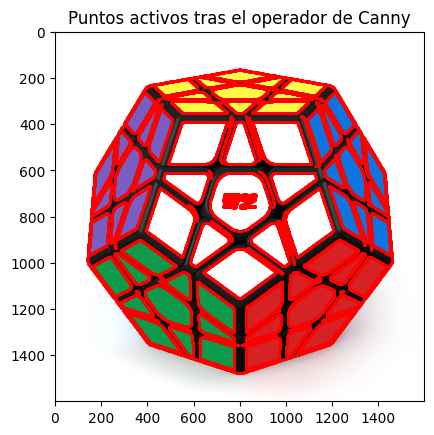

In [ ]:
ruta = "ComputerVisionFiles/megaminx.jpg"
active_points_X , active_points_Y = active_points_plot(ruta_imagen=ruta,show=True)

Hay un total de 73157 pixeles activos tras el operador de Canny


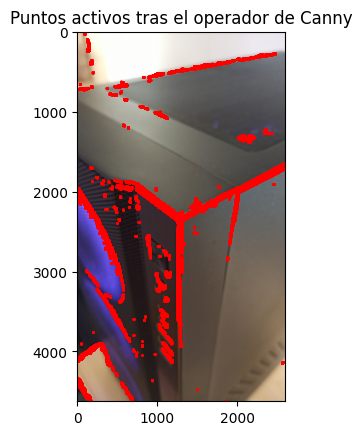

In [ ]:
ruta = "ComputerVisionFiles/PC.jpg"
active_points = active_points_plot(ruta_imagen=ruta,Canny_threshold1=20,Canny_threshold2=60)

interactive(children=(IntSlider(value=1040, description='Center X:', max=2080), IntSlider(value=1849, descript…

Button(description='Guardar ROI', style=ButtonStyle())

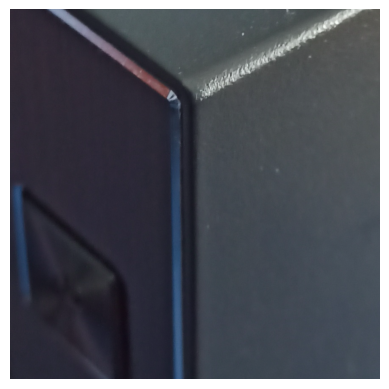

ROI guardada como 'roi.jpg'.
Coordenadas del rectángulo:
Esquina superior izquierda: (690, 1708)
Esquina inferior derecha: (1390, 2408)


In [ ]:
ruta = "ComputerVisionFiles/PC.jpg"
img1 = cv2.imread(ruta)
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
ROI_selection_colab(image_path=ruta,w=350,h=350)


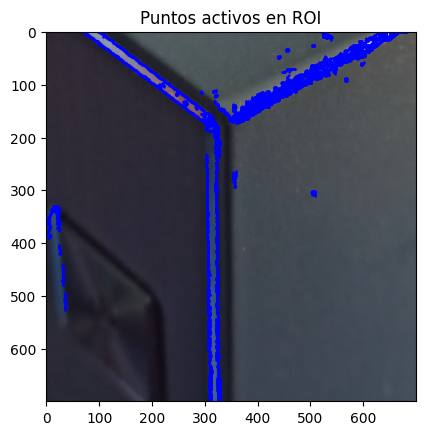

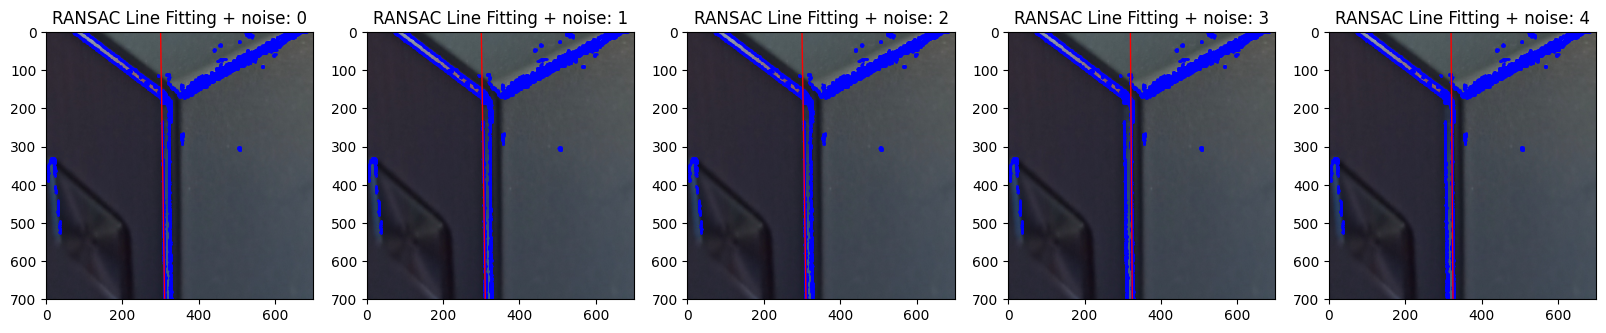

In [89]:
ruta = "roi.jpg"
img1 = cv2.imread(ruta)
ROI = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
RANSAC_loop_with_points_ROI_colab(image=ROI,loop=5)

### - ``Pruebas en local``


Hay un total de 51717 pixeles activos tras el operador de Canny


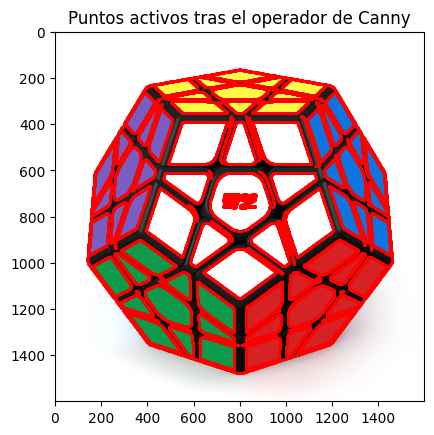

In [56]:
ruta = "megaminx.jpg"
active_points_X , active_points_Y = active_points_plot(ruta_imagen=ruta,show=True)

Hay un total de 73157 pixeles activos tras el operador de Canny


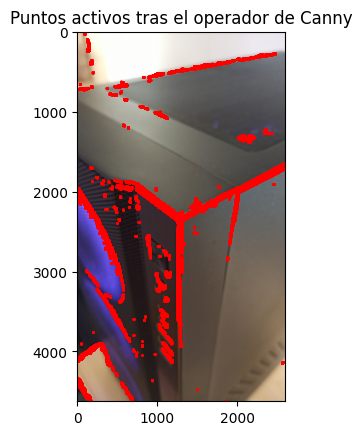

In [14]:
ruta = "PC.jpg"
active_points = active_points_plot(ruta_imagen=ruta,Canny_threshold1=20,Canny_threshold2=60)

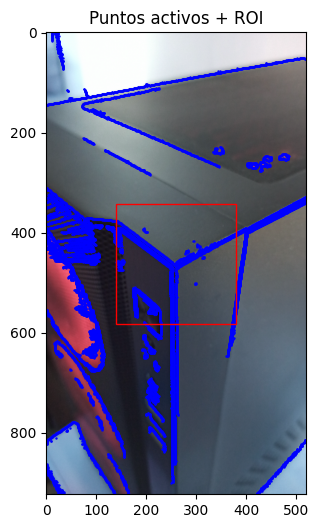

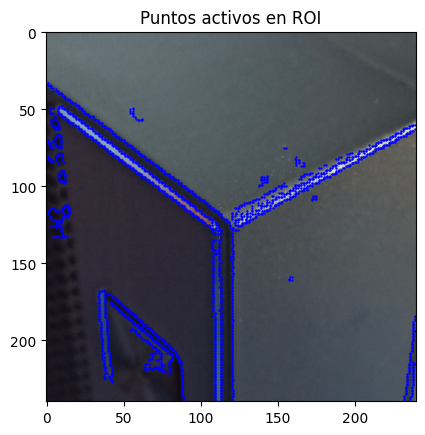

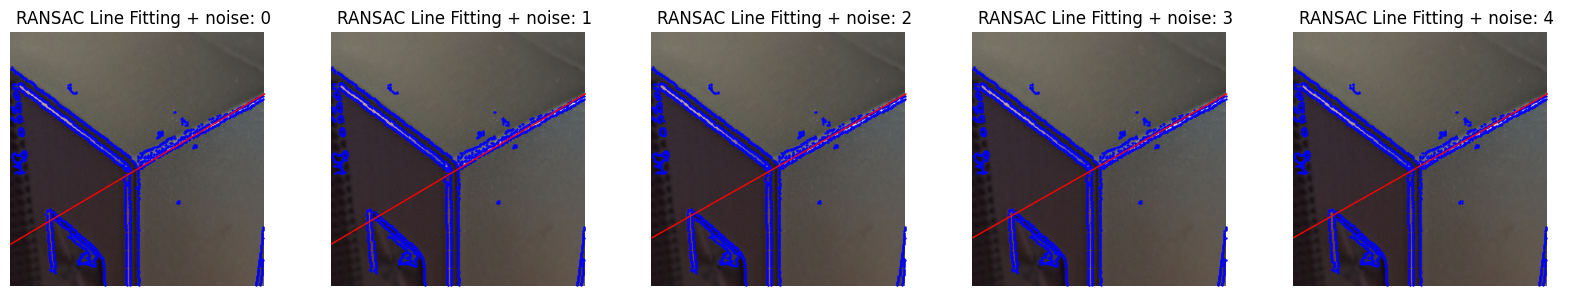

In [17]:
ruta = "PC.jpg"
RANSAC_loop_with_points_ROI(ruta,loop=5) 

### - ``Conclusiones``

1. El plot de los puntos de borde usando *active_points_plot* funciona fantásticamente, aunque he de decir que la imagen se ha escogido con la idea de que sea "buena" para detección de bordes

2. De nuevo sobre la segunda imagen de la carcasa de un PC, la detección de bordes con esta función (esta vez con distintos umbrales) sigue funcionando perfectamente, y podemos  
apreciar más abajo que en la ROI encuadrada en rojo se cumple el requisito de testeo pedido en el enunciado: hemos seleccionado una zona puntiaguda donde hay puntos de borde activos   
que confluyen en el pico y provienen de diferentes rectas. En los últimos plots vemos cómo a pesar de intentar perturbar el algoritmo con este "exceso de bordes",  
se comporta robustamente en este caso. Podemos probar con la ROI de la esquina superior izquierda y ver que de nuevo el resultado es muy satisfactorio.

## <div style="background-color: #54c7ec; color: #fff; font-weight: 700; padding-left: 10px; padding-top: 5px; padding-bottom: 5px"><strong>Ejercicio OP2A (0.3 pts)</strong></div>

- Realizar un breve estudio estadístico práctico con el algoritmo desarrollado, donde se ilustre bien cuántas pruebas son necesarias  
para que el RANSAC converja, dependiendo del porcentaje de outliers presentes. Se puede usar para ello una generación de datos (puntos) sintéticos, creados ad-hoc,  
y se valorará la realización de algún tipo de visualización gráfica de los resultados, mediante matplotlib, seaborn o librerías similares.

Para resolver el ejercicio, modificaremos brevemente la función *RANSAC_sinlge_fit* para que devuelva los datos estadísticos relativos a cada ejecución del algoritmo RANSAC que hemos creado.   
Ceramos para ello una nueva función: *RANSAC_convergence_test_lite*. Posteriormente y conociendo estos datos, los mostraremos gráficamente usando ``matplotlib``.

### -``Definición de funciones auxiliares``

* *generate_synthetic_data* :   
Genera puntos de borde de forma aleatoria sobre una imagen cuadrada binaria de fondo negro. Traza también una recta sobre la iamgen y devuelve   
las coordenadas de los puntos activos (bordes + recta). La cantidad de outliers respecto de la recta, se calculan en base a un porcentaje que pasamos por parámetro

* *RANSAC_convergente_test_lite* :   
Hace un plot para cada proporción de outleirs elegida, donde a al izquierda en azul tenemos un gráfico que muestra el número de iteraciones necesarias promedio   
hasta convergencia de RANSAC; calculado de forma empírica. A la derecha en rojo se muestra el número de iteraciones teóricamente estimadas para asegurar esa convergencia   
con un error predefinido (ponemos 0.01)


In [7]:
def generate_synthetic_data(n, outlier_ratio=0.002, total_points_ratio=0.15, slope=3, intercept=2):

    ''' Devuelve una matriz de tamaño n con valores binarios, teniendo en cuenta la proporción de outliers, el numero de puntos totales y una recta de referencia para los inliers '''

    # Crear matriz vacía de nxn con ceros
    matrix = np.zeros((n, n), dtype=int)
    
    # Calcular la cantidad de inliers y outliers
    num_outliers = int(outlier_ratio * total_points_ratio*n)
    num_inliers = int(total_points_ratio*n) - num_outliers
    
    # Generar puntos de inliers alrededor de la recta
    for _ in range(num_inliers):
        # Escoger una coordenada x aleatoria en el rango de la matriz
        x = random.randint(0, n-1)
        # Calcular la coordenada y de acuerdo a la ecuación de la recta: y = mx + b
        y = int(slope * x + intercept)
        
        # Asegurar que el punto (x, y) esté dentro de los límites de la matriz
        if 0 <= y < n:
            matrix[y, x] = 1  # Marcar como inlier
    
    # Generar puntos de outliers en posiciones aleatorias
    for _ in range(num_outliers):
        x = random.randint(0, n-1)
        y = random.randint(0, n-1)
        matrix[y, x] = 1  # Marcar como outlier
    
    return matrix

In [19]:
def RANSAC_convergence_test_lite(samples=20, space_size=400, outlier_ratios = [0.1,0.25,0.5,0.7], inliers_threshold_list=[0.05,0.1,0.15], 
                            min_inliers_list=[0.01,0.02,0.03],fail_prob=0.01,show=True):

    ''' Test '''

    

    for r in range(len(outlier_ratios)):

        max_iterations = int(math.log(fail_prob)/math.log(1-(1-outlier_ratios[r])**2))+1
        labels = [str(outlier_ratios[r]),"Valor esperado"]
        
       
        for t in range(len(inliers_threshold_list)):

            acceptance_range = int(inliers_threshold_list[t]*space_size)
            
            for m in range(len(min_inliers_list)):

                iteraciones = []
                binary_sample = generate_synthetic_data(n=space_size,outlier_ratio=outlier_ratios[r],total_points_ratio=0.15,slope=3,intercept=2)
                points = np.argwhere(binary_sample != 0)
                
                min_inliers = int(min_inliers_list[m]*space_size)
                counter = 0

                for _ in range(samples):
                    for _ in range(2*max_iterations):
                    

                        counter += 1

                        # Selecciona aleatoriamente dos puntos de borde
                        sample_points = points[np.random.choice(points.shape[0], 2, replace=False)]

                        # Define la recta (y = mx + b) usando los dos puntos
                        (x1, y1), (x2, y2) = sample_points
                        if x1 == x2:  # Evita la división por cero
                            continue
                        m = (y2 - y1) / (x2 - x1)  # sin(alpha) para la pendiente de la recta
                        b = y1 - m * x1            # b se despeja trivialmente conociendo m

                        # Calcula los inliers
                        inliers = []
                        for x, y in points:
                            distance = abs(m * x - y + b) / np.sqrt(m**2 + 1)
                            if distance < acceptance_range:
                                inliers.append((x, y))

                        # Comprueba si es el mejor modelo hasta ahora
                        if len(inliers) > min_inliers:
                            #best_line = (m, b)
                            break

                        # Comprueba si es el mejor modelo hasta ahora
                        #if (x1,y1) in points and (x2,y2) in points:
                        #    break

                    
                
                iteraciones.append(counter/samples)
                iteraciones.append(max_iterations)

                if show == True:
                    # Define las etiquetas y valores
                    colores = ['blue', 'red']  # Puedes cambiar los colores

                    # Crea el gráfico de barras
                    plt.figure(figsize=(10, 3))
                    plt.bar(labels, iteraciones, color=colores)

                    # Añade etiquetas y título
                    plt.xlabel("Porcentaje de outliers     VS     Valor esperado")
                    plt.ylabel("Iteraciones estimadas para convergencia")
                    plt.title("Iteraciones RANSAC: (samples="+str(samples)+", "+"inliers_threshold="+str(acceptance_range)+", "+"convergence_criteria="+str(min_inliers)+")")

                    # Muestra el gráfico
                    plt.show()  


### - ``Prueba``

El criterio de convergencia respecto del cual se realiza el cálculo teórico de "mínimo de iteraciones necesarias de RANSAC para asegurar convergencia al 99%", es basatnte pobre:  
simplemente se basa en discernir si los dos puntos de arranque elegidos para RANSAC son puntos inlier respecto de la recta en la imagen o no. Pero pensamos que este criterio de converegncia 
es demasiado flojo, y queríamos añadir condicionamiento relativo a la anchura de la banda de aceptación para el cálculo de inliers y el número mínimo de inliers que necesitamos para validar
una iteración. Por supuesto, manteniendo también la influencia del factor "proporción de outliers en la muestra".

El estudio que vamos a realizar pretende señalar las diferencias entre las iteraciones esperadas de forma teórica y las necesitadas en la practica para asegurar convergencia al 99%.
Para ello necesitamos analizar gráficamente la influencia de cada uno de los factores añadidos.

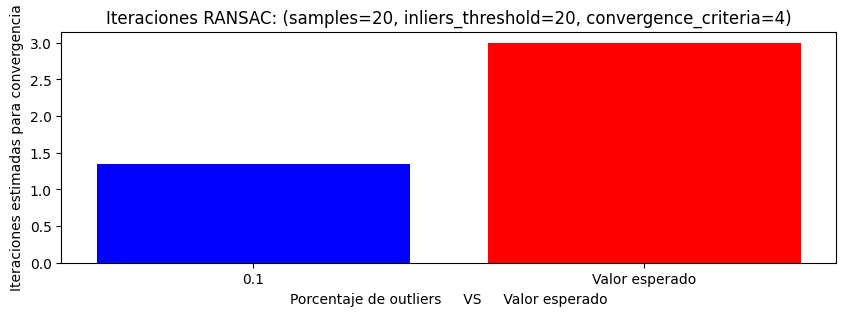

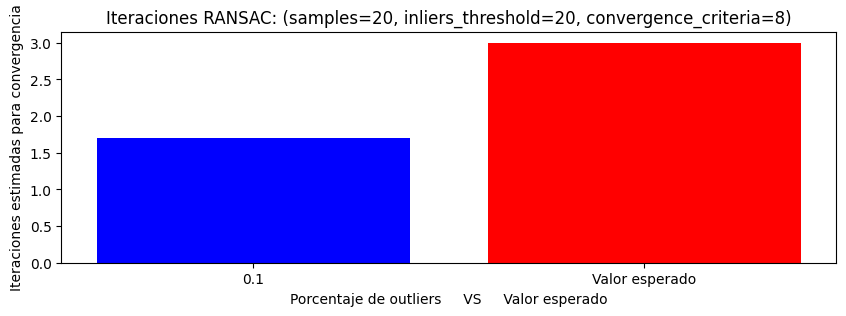

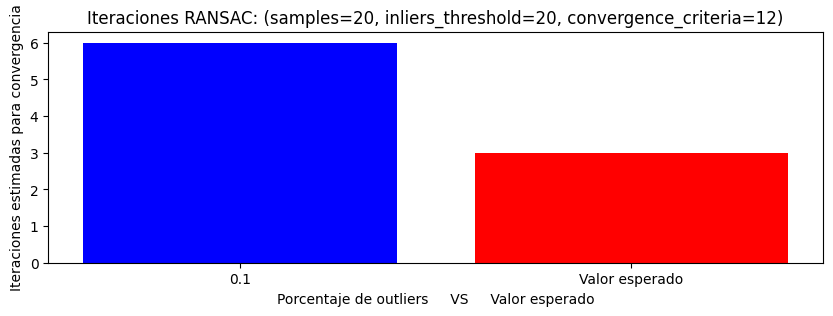

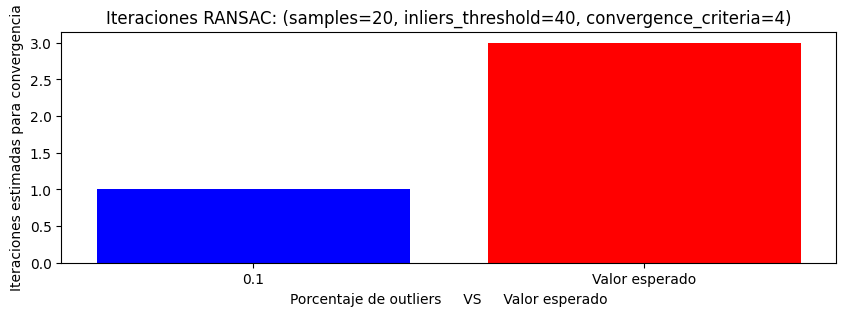

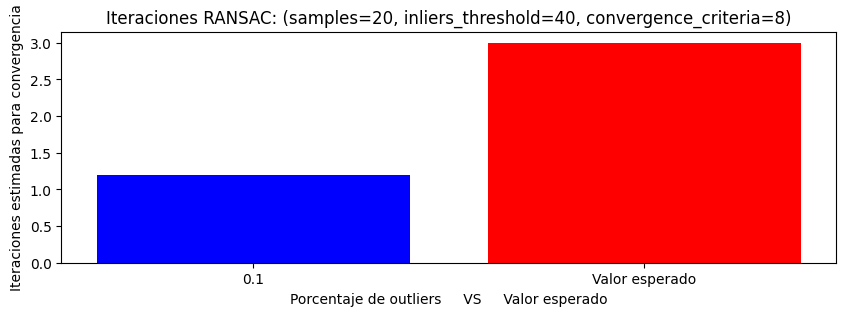

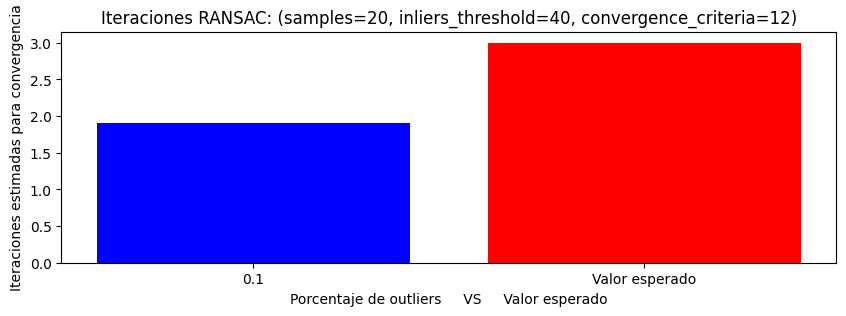

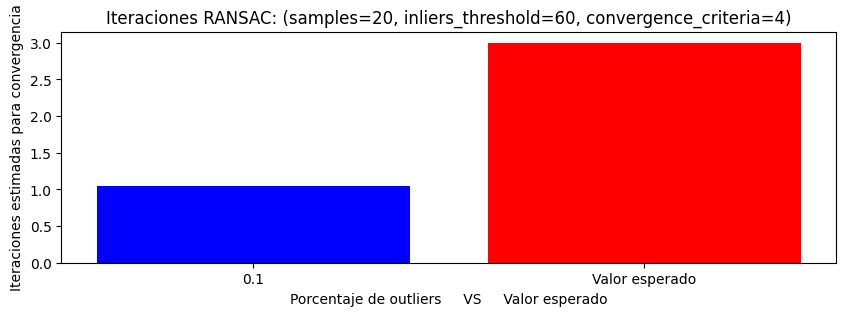

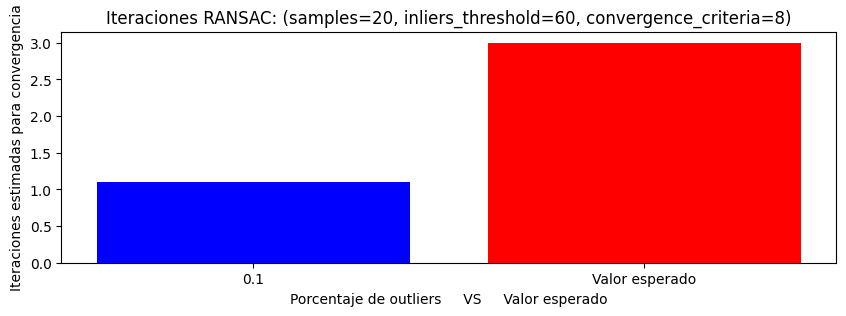

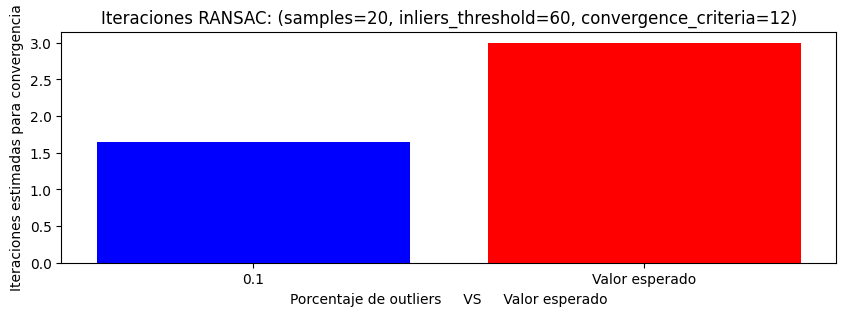

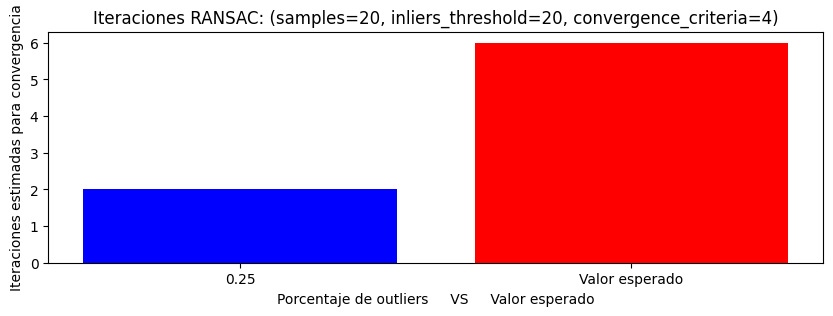

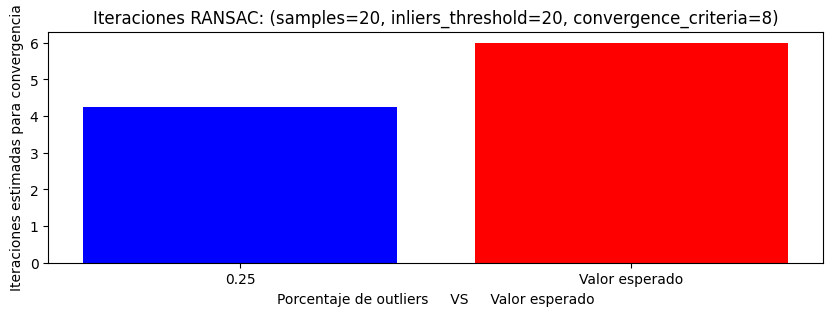

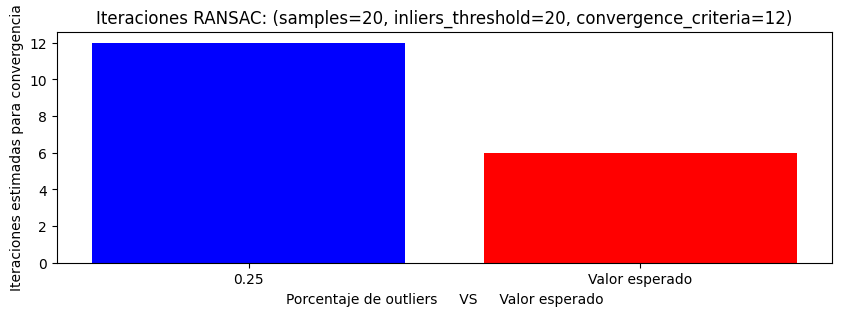

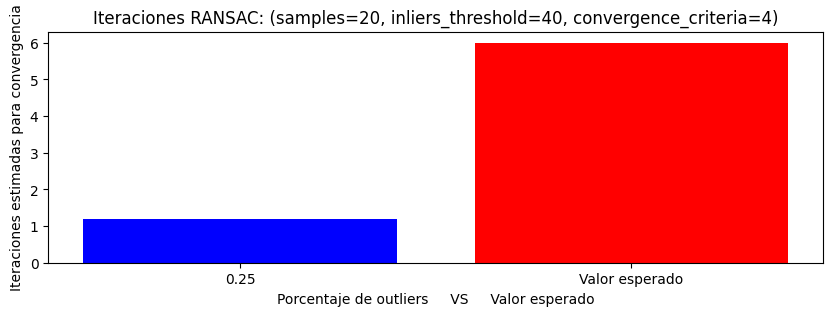

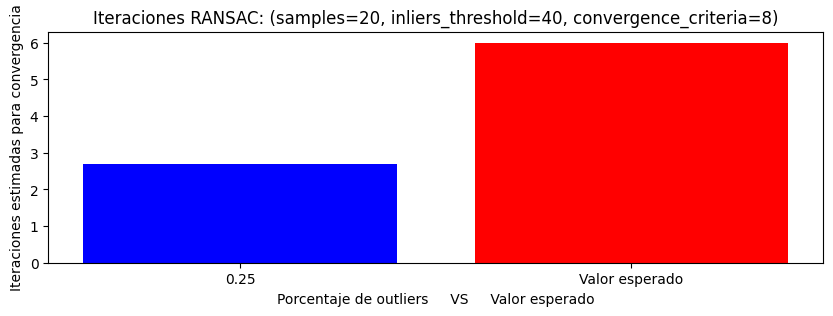

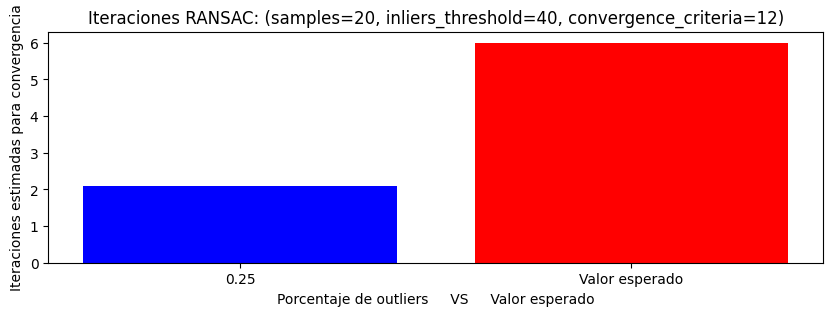

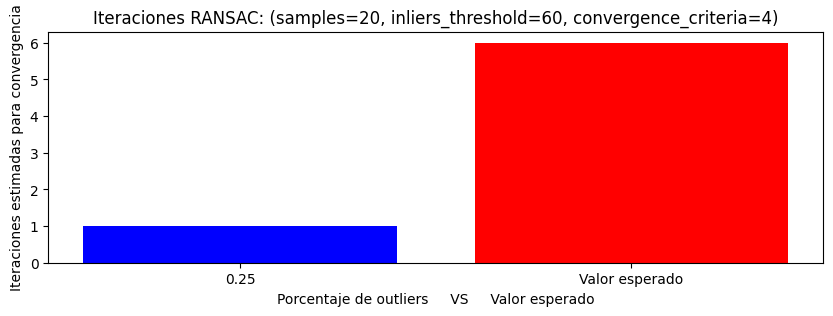

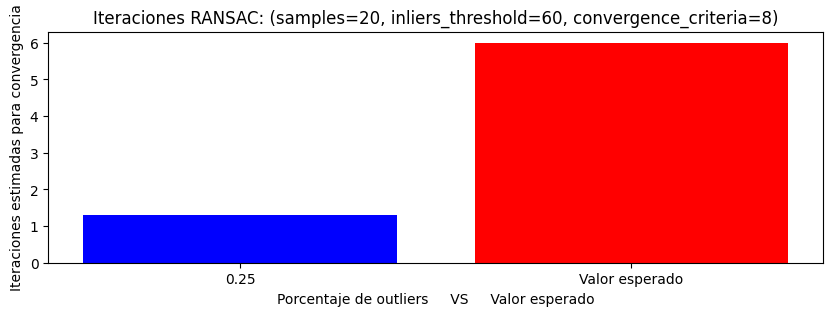

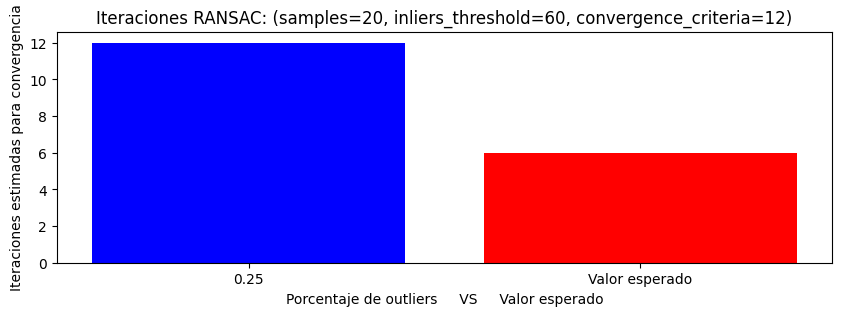

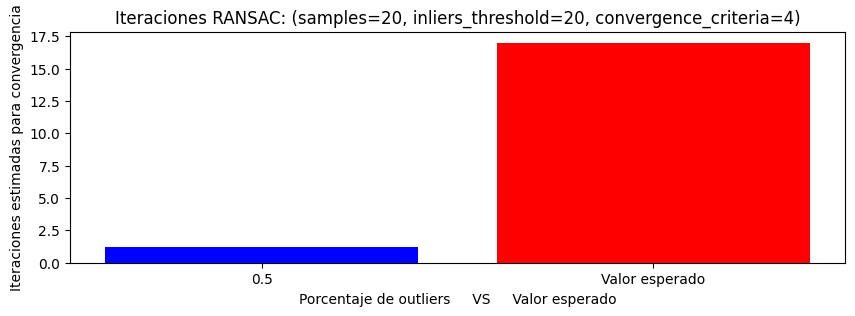

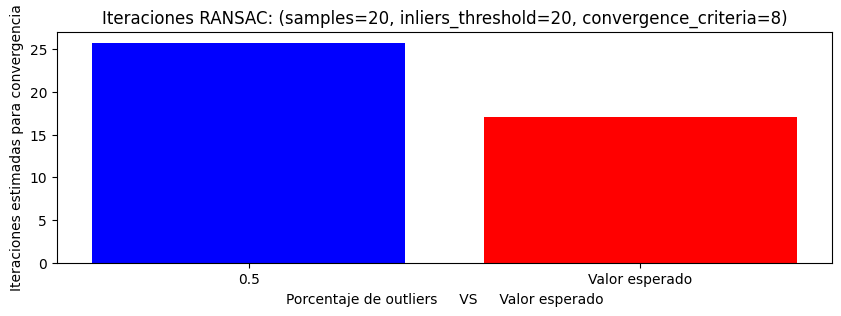

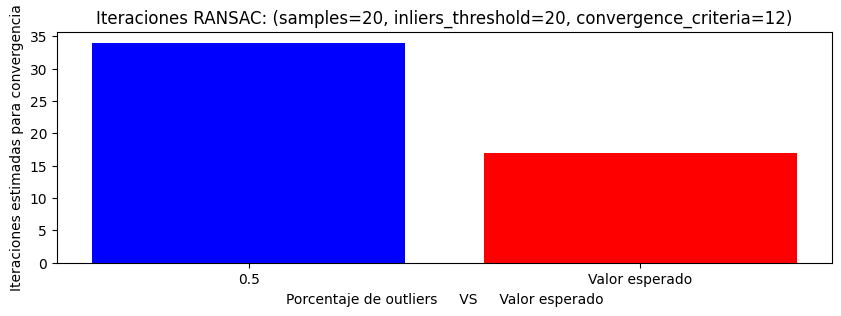

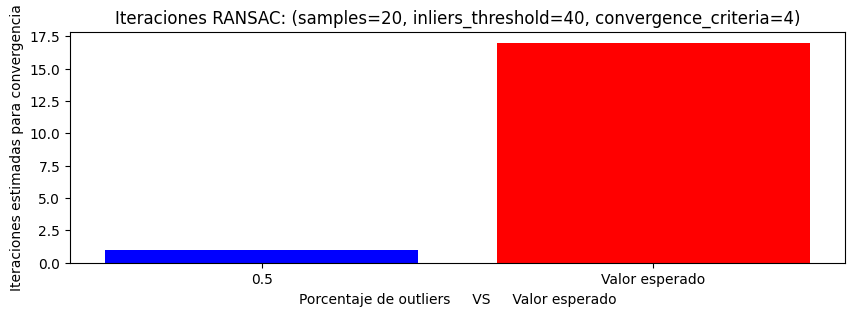

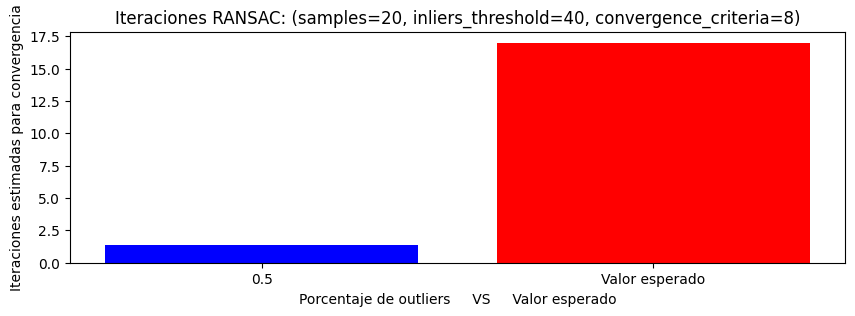

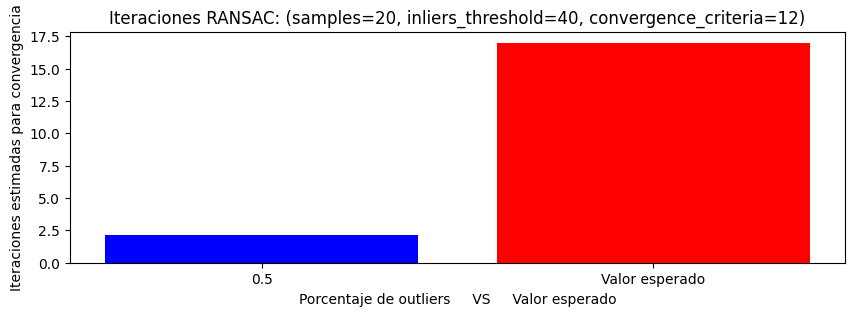

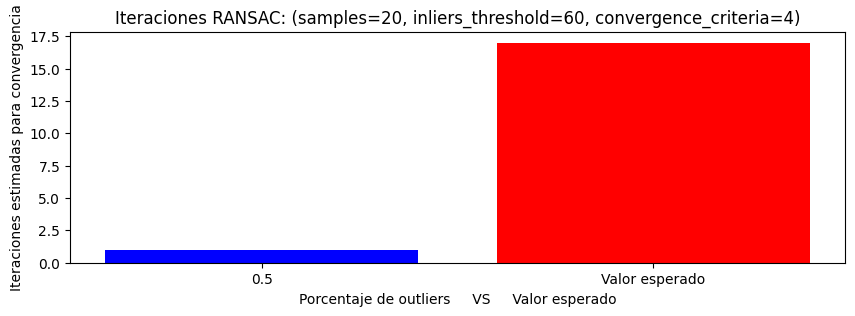

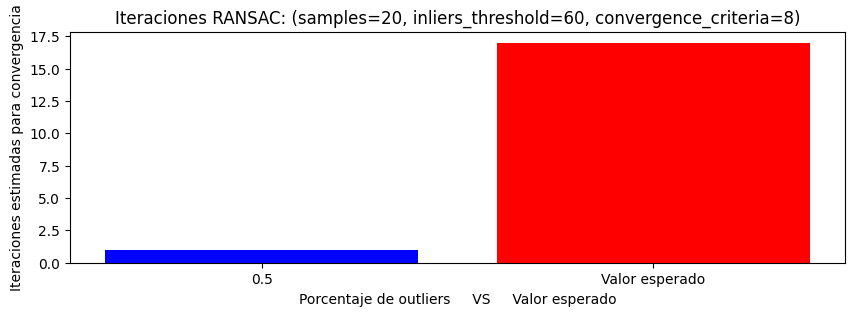

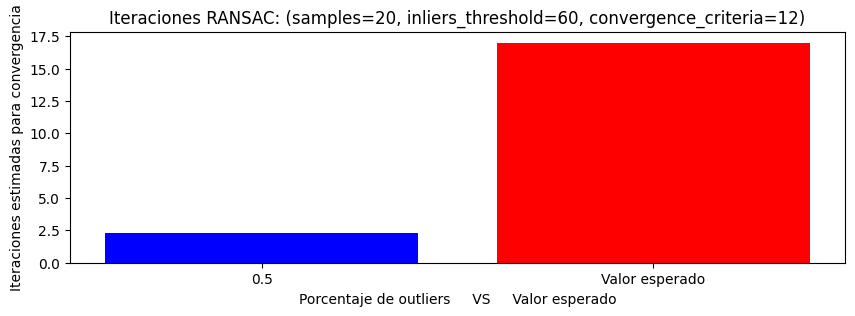

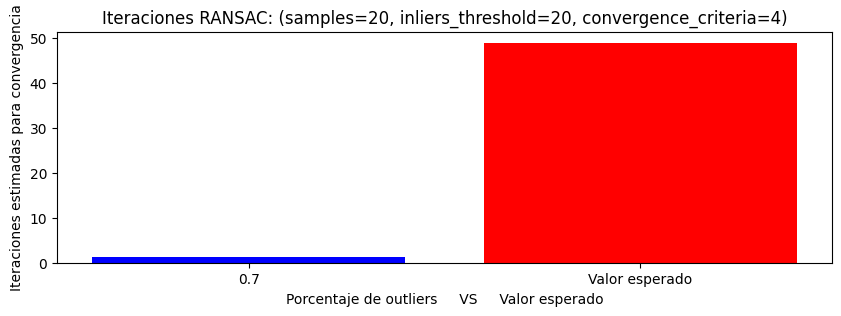

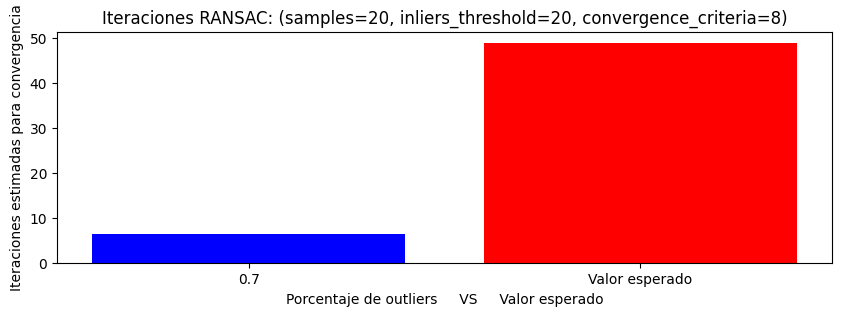

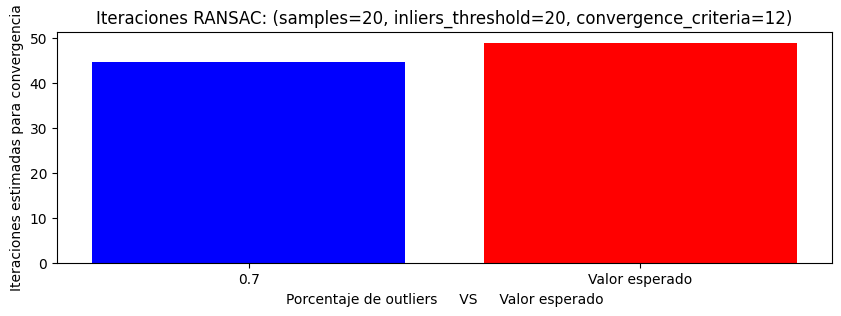

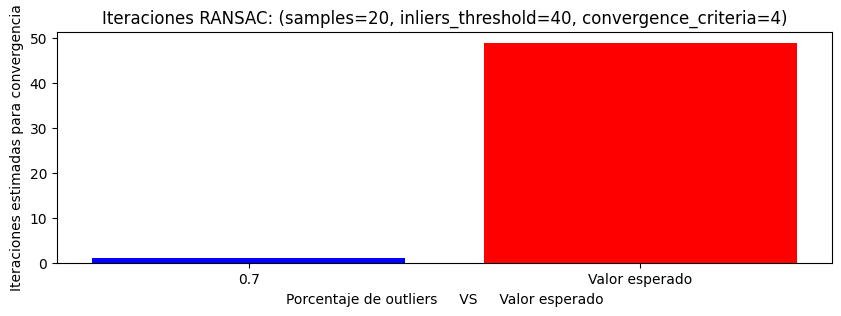

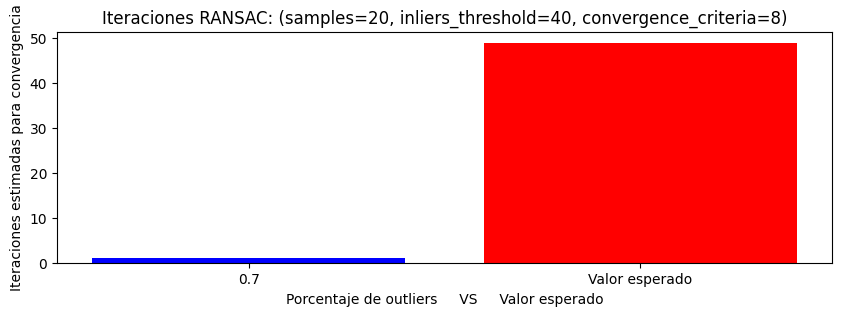

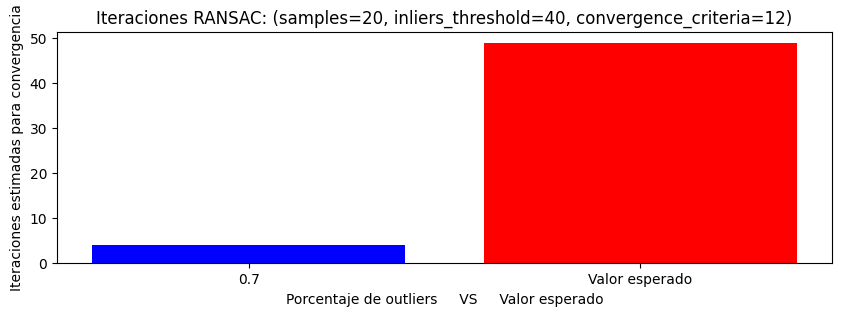

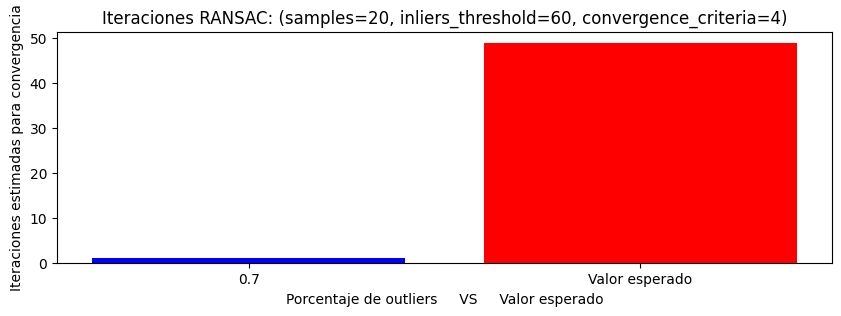

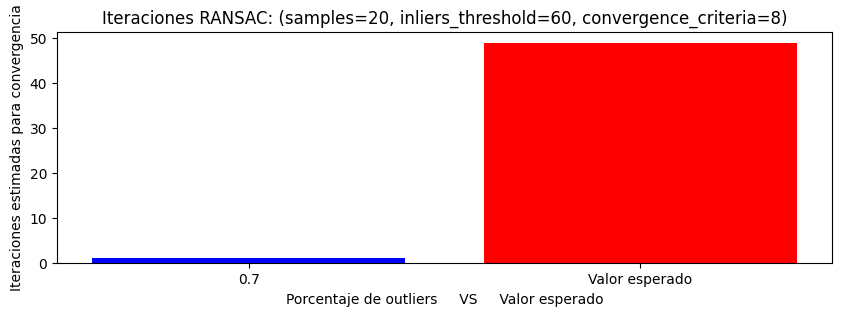

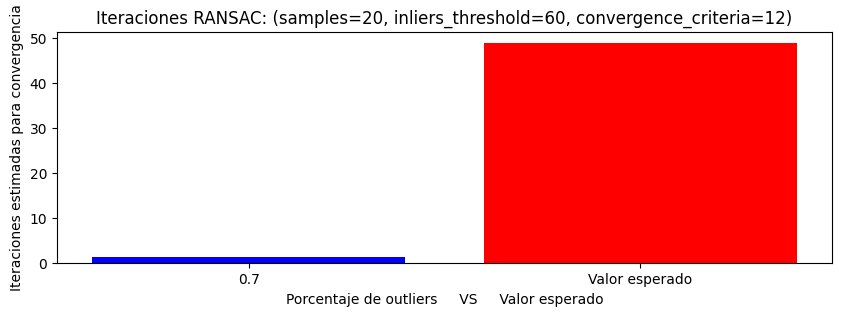

In [20]:
RANSAC_convergence_test_lite()

### - ``Conclusiones``

Las comparaciones entre iteraciones promedio e iteraciones esperadas fluctúan mucho según el valor de la banda de aceptación de inliers y el criterio de convergencia (número mínimo de inliers  
para validar una solución de RANSAC). Los plots están dispuestos de forma que, fijada la proporción de outliers en la muestra, varíen los otros dos parámetros y así opder ir comparando.

De forma general, el número de iteraciones promedio es directamente proporcional al criterio de convergencia (*convergence_criteria* == "mínimo de inliers para validar iteración") e   
inversamente proporcional a la anchura de la banda de aceptación (*inliers_threshold*).

Cuando ambos valores son muy bajos, se endurecen las condiciones para que una iteración de RANSAC sea considerada válida, y eso se hace evidente al ver que para cualquier   
proporción de outliers fijada.

Además, podemos observar en las gráficas que por lo general los resultados son mucho más sensibles al parámetro del criterio de convergencia que al de la anchura de la banda de aceptación.

## <div style="background-color: #54c7ec; color: #fff; font-weight: 700; padding-left: 10px; padding-top: 5px; padding-bottom: 5px"><strong>Ejercicio OP2C (0.2 pts)</strong></div>

- Aumentar cualquiera de los algoritmos de detección de rectas / círculos (o ambos) para que resuelvan el caso de múltiples instancias (varias rectas/círculos en el ROI)

### - ``Modificación para líneas``

In [21]:
def RANSAC_n_fit(image,n=5,Canny_threshold1=100, Canny_threshold2=200, num_iterations=100, inliers_threshold=2, min_inliers=50,show=True):

    ''' Implementa a mano el metodo RANSAC para que detecte n líneas distintas en la imagen dada '''

    # Obtenemos los puntos de borde con el operador de Canny
    edges = cv2.Canny(image,Canny_threshold1,Canny_threshold2)   # (imagen,threshold1,threshold2)

    # Encuentra puntos de borde
    points = np.argwhere(edges != 0)  # Encuentra coordenadas (y, x) de bordes
    points = np.flip(points, axis=1)  # Invierte a (x, y)


    chooseable_points = points.copy()   # Conjunto que albergará los puntos activos disponibles para el random choosing del RANSAC en cada una de las n iteraciones
    remaining_points = points.copy()    # Conjunto de puntos activos disponibles enc ada etapa iterativa del RANSAC
    # inlier_set = {}  
    best_line = None
    max_inliers = 0
    lines=[]                    # Almacena las líneas detectadas en cada iteración (n iteraciones)
    inliers_absolute_list=[]    # Contiene los inliers detectados por cada mejor recta RANSAC en cada iteración
    
    

    while True:     
        
        best_line = None
        max_inliers = 0
        remaining_points = chooseable_points.copy() # Al principio de cada iteración siempre partimos de que los puntos restantes son los puntos escogibles
        
        for _ in range(num_iterations):
            # Selecciona aleatoriamente dos puntos de borde
            sample_points = remaining_points[np.random.choice(remaining_points.shape[0], 2, replace=False)]

            # Define la recta (y = mx + b) usando los dos puntos
            (x1, y1), (x2, y2) = sample_points
            if x1 == x2:  # Evita la división por cero
                continue
            m = (y2 - y1) / (x2 - x1)  # sin(alpha) para la pendiente de la recta
            b = y1 - m * x1            # b se despeja trivialmente conociendo m

            # Calcula los inliers
            inliers = []
            for x, y in chooseable_points:
                distance = abs(m * x - y + b) / np.sqrt(m**2 + 1)
                if distance < inliers_threshold:
                    inliers.append((x, y))                # Actualizamos la lista de inliers local
                    
            # Comprueba si la recta extraída es la mejor hasta ahora para el par de sample_points dado
            if len(inliers) > max_inliers and len(inliers) > min_inliers:
                max_inliers = len(inliers)
                best_line = (m, b)

            # Actualizamos la lista de remaining points, de donde se extraen los sample points de cada etapa RANSAC
            inlier_set = set(inliers)
            remaining_points = np.array([pt for pt in remaining_points if tuple(pt) not in inlier_set])

        inliers_absolute_list += inliers       # Actualizamos la lista de inliers global
        inliers_absolute_list += [(x1, y1), (x2, y2)]       

        if best_line is None or len(inliers) < min_inliers or len(lines) >= n:
            break  # No hay más líneas significativas o hemos llegado al límite que queríamos (n)
        lines.append(best_line)

        # Eliminar los puntos inliers de los puntos restantes a escoger para hallar otra recta
        inlier_global_set = set(inliers_absolute_list)
        chooseable_points = np.array([pt for pt in chooseable_points if tuple(pt) not in inlier_global_set])

    
    if show == True:

        # Dibuja las líneas en la imagen
        image_with_lines = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (0, 255, 255)]

        for i, (m, b) in enumerate(lines):
            color = colors[i % len(colors)]
            h, w = image.shape[1] , image.shape[0]
            pt1 = (0, int(b))
            pt2 = (w, int(m * w + b))
            cv2.line(image_with_lines, pt1, pt2, color, 2)

        # Muestra la imagen con la recta estimada
        plt.imshow(image_with_lines)
        plt.axis('off')  # Ocultar los ejes
        plt.title("RANSAC Line Fitting")
        plt.show()
    else:
        print("No se encontró una línea válida.")  

    return lines


In [22]:
def RANSAC_n_segments(image, n=5, Canny_threshold1=100, Canny_threshold2=200, num_iterations=100, inliers_threshold=2, min_inliers=50, show=True):
    ''' Implementa el método RANSAC para detectar n segmentos de línea distintos en la imagen dada '''
    
    # Detecta los bordes en la imagen
    edges = cv2.Canny(image, Canny_threshold1, Canny_threshold2)
    points = np.argwhere(edges != 0)
    points = np.flip(points, axis=1)

    chooseable_points = points.copy()
    lines = []
    inliers_absolute_list = []
    
    for _ in range(n):  # Detecta hasta 'n' segmentos
        
        best_line = None
        max_inliers = 0
        best_inliers = []
        
        for _ in range(num_iterations):
            # Selección aleatoria de dos puntos para definir la línea
            sample_points = chooseable_points[np.random.choice(chooseable_points.shape[0], 2, replace=False)]
            (x1, y1), (x2, y2) = sample_points
            if x1 == x2:
                continue  # Evita la división por cero
            
            m = (y2 - y1) / (x2 - x1)  # Pendiente
            b = y1 - m * x1            # Intercepto

            # Calcula los inliers para la línea
            inliers = []
            for x, y in chooseable_points:
                distance = abs(m * x - y + b) / np.sqrt(m**2 + 1)
                if distance < inliers_threshold:
                    inliers.append((x, y))
            
            # Verifica si es la mejor línea encontrada hasta el momento
            if len(inliers) > max_inliers and len(inliers) > min_inliers:
                max_inliers = len(inliers)
                best_line = (m, b)
                best_inliers = inliers

        if best_line is None:
            break  # No se encontró una línea significativa

        # Calcula el segmento utilizando los inliers
        inliers_x = np.array([x for x, y in best_inliers])
        lower_percentile = 20
        upper_percentile = 80
        if len(inliers_x) > 1:
            x_start = np.percentile(inliers_x, lower_percentile)
            x_end = np.percentile(inliers_x, upper_percentile)

            if x_start != x_end:
                y_start = int(best_line[0] * x_start + best_line[1])
                y_end = int(best_line[0] * x_end + best_line[1])
                lines.append(((int(x_start), y_start), (int(x_end), y_end)))

        # Actualiza los puntos para el próximo segmento y agrega inliers actuales a la lista absoluta
        inliers_absolute_list += best_inliers
        inlier_global_set = set(inliers_absolute_list)
        chooseable_points = np.array([pt for pt in chooseable_points if tuple(pt) not in inlier_global_set])
    
    # Muestra los segmentos si está habilitado
    if show:
        image_with_segments = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (0, 255, 255)]
        for i, (start_pt, end_pt) in enumerate(lines):
            color = colors[i % len(colors)]
            cv2.line(image_with_segments, start_pt, end_pt, color, 2)

        # Muestra la imagen con los segmentos estimados
        plt.imshow(image_with_segments)
        plt.axis('off')
        plt.title("RANSAC Segment Fitting")
        plt.show()
    else:
        print("No se encontraron segmentos válidos.")
    
    return lines

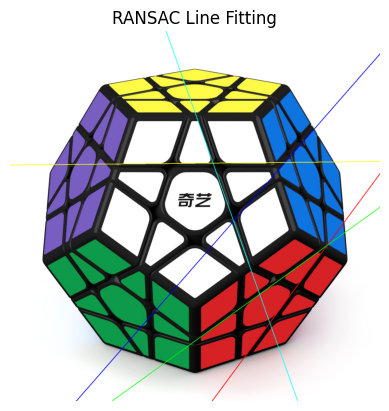

In [ ]:
# Probamos con una imagen propicia

imgName = "ComputerVisionFiles/megaminx.jpg"
image = cv2.imread(imgName)
lines = RANSAC_n_fit(image=image,n=5)

interactive(children=(IntSlider(value=800, description='Center X:', max=1600), IntSlider(value=800, descriptio…

Button(description='Guardar ROI', style=ButtonStyle())

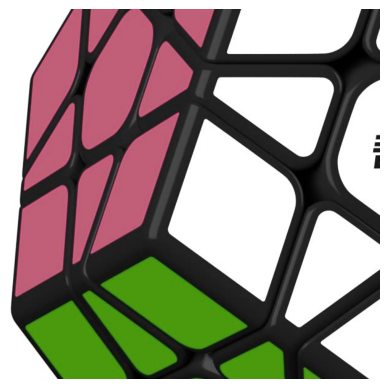

ROI guardada como 'roi.jpg'.
Coordenadas del rectángulo:
Esquina superior izquierda: (139, 500)
Esquina inferior derecha: (739, 1100)


In [ ]:
path='ComputerVisionFiles/megaminx.jpg'
ROI_selection_colab(image_path=path,w=300,h=300,resize_factor=1)

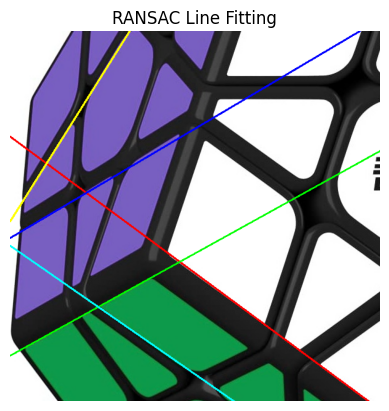

In [ ]:
# Detectamos 5 líneas

ruta = "roi.jpg"
img1 = cv2.imread(ruta)
ROI = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
lines = RANSAC_n_fit(image=ROI,n=5)

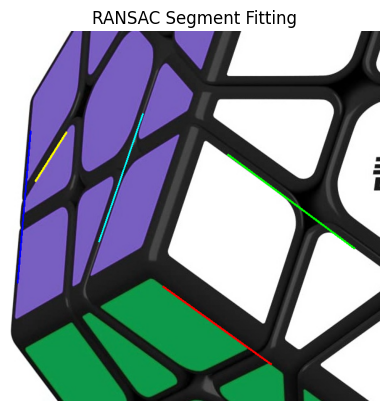

In [99]:
# Repetimos pero mostrando 5 segmentos con la otra función 

lines = RANSAC_n_segments(image=ROI,n=5)

### - ``Modificación para círculos``

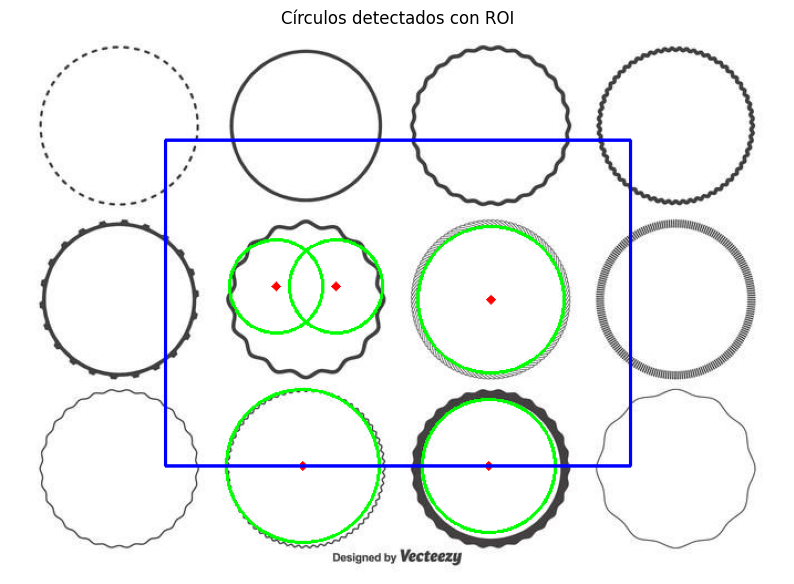

In [ ]:
# Cargamos la imagen
#image = cv2.imread('monedas3.png')
image = cv2.imread('ComputerVisionFiles/circulos2.jpg')


# Obtenemos dimensiones de la imagen
height, width = image.shape[:2]

# Definir ROI como porcentaje del tamaño de la imagen
roi_percentage = 0.6  # 1 para la imagen completa, 50% para la mitad. 

# Calcular coordenadas para ROI
x_start = int(width * (1 - roi_percentage) / 2)  # Centrado
y_start = int(height * (1 - roi_percentage) / 2)
roi_width = int(width * roi_percentage)
roi_height = int(height * roi_percentage)

# Extrayendo ROI de la imagen
roi = image[y_start:y_start + roi_height, x_start:x_start + roi_width]

# Convertir ROI a escala de grises para procesamiento
roi_gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)

# Aplicar desenfoque Gaussiano al ROI
roi_gray = cv2.GaussianBlur(roi_gray, (9, 9), 2)

# Detectar cículos usando HoughCircles en ROI
circles = cv2.HoughCircles(
    roi_gray,
    cv2.HOUGH_GRADIENT,
    dp=1,
    minDist=30,
    param1=50,
    param2=35,   #Reducir estos valores para detectar más círculos.
    minRadius=5,
    maxRadius=100  #Detectar círculos de cualquier radio
)

# Si se detecta algún círculo
if circles is not None:
    circles = np.uint16(np.around(circles))
    for i in circles[0, :]:
        # Dibuja el círculo exterior en la imagen original.
        cv2.circle(image, (i[0] + x_start, i[1] + y_start), i[2], (0, 255, 0), 2)
        # Dibuja el centro del círculo
        cv2.circle(image, (i[0] + x_start, i[1] + y_start), 2, (0, 0, 255), 3)

# Dibuja un rectángulo alrededor del ROI (opcional)
cv2.rectangle(image, (x_start, y_start), (x_start + roi_width, y_start + roi_height), (255, 0, 0), 2)

# Convertir la imagen del formato BGR a RGB
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Plotear resultados con Matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(image_rgb)
plt.axis('off')  # Turn off axis numbers and ticks
plt.title('Círculos detectados con ROI')
plt.show()